In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.cluster import KElbowVisualizer

In [3]:
sns.set_palette(['#088395', '#00FFCA', '#0A4D68', '#05BFDB', '#B9EDDD'])

In [4]:
data = pd.read_csv('/content/churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# TotalCharges has to be converted to float
def convert_to(x, output_type=float):
  if x == ' ':
    return 0.0
  else:
    return output_type(x)

In [7]:
data['TotalCharges'] = data['TotalCharges'].apply(convert_to)

In [8]:
categorical_features = []
numerical_features = []

for col in data.columns:
  if len(data[col].unique())<=10:
    categorical_features.append(col)
  else:
    numerical_features.append(col)

print('numerical_features = ', numerical_features)
print('categorical_features = ', categorical_features)

numerical_features =  ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features =  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [9]:
data.drop('customerID', axis=1, inplace=True)

In [10]:
print(data.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
#1 - Dealing with outliers

def identify_outliers(data: pd.DataFrame, col: str, is_outlier: bool=False):
  # calculate interquartile range
  q25, q75 = np.percentile(data[col], 25), np.percentile(data[col], 75)
  iqr = q75 - q25
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  # give the actual limits on the data
  lower, upper = q25 - cut_off, q75 + cut_off
  is_outlier_df = data[(data[col]<lower) | (data[col]>upper)]

  if len(is_outlier_df)>0:
    print(f'There are some outliers in {col} column.')
  else:
    print(f'There is no outlier in {col} column.', '\n')

  if is_outlier:
    cleaned_data = data[(data[col]>lower) & (data[col]<upper)]
    print('All outliers have been removed.')
    return cleaned_data

In [15]:
#2 - Label Encoding

#Label Encoding the object dtypes.

LE = preprocessing.LabelEncoder()
preprocessed_data = data.copy()
for col in categorical_features:
    preprocessed_data[col]=preprocessed_data[[col]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


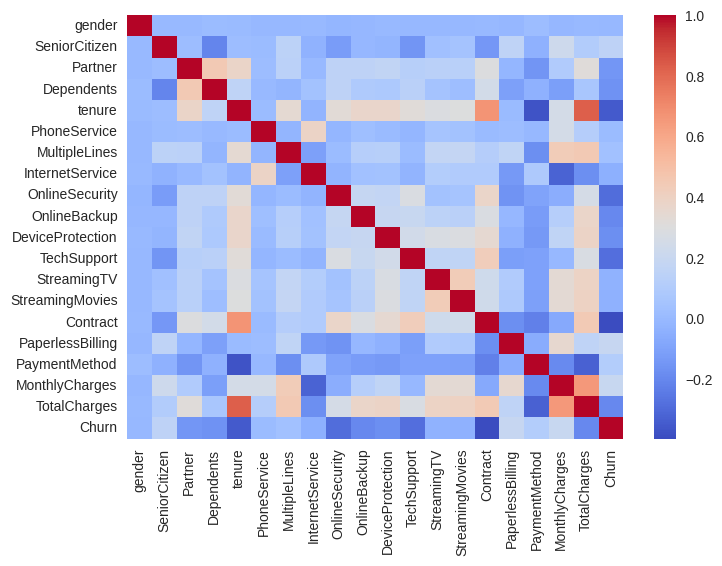

In [16]:
# Correlation of features
sns.heatmap(preprocessed_data.corr(), cmap='coolwarm');

In [17]:
#3 - Standardizing
x_scaled = preprocessing.scale(preprocessed_data)
scaled_df = pd.DataFrame(x_scaled, columns=preprocessed_data.columns)

In [18]:
#4 - Dimentionality Reduction
pca = PCA(n_components=3)
pca.fit(scaled_df)
pca_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1","col2", "col3"]))

pca_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,7043.0,5.044319e-18,2.081423,-3.864279,-1.654108,-0.266278,1.427180,5.543566
col2,7043.0,-7.062046e-18,1.587306,-3.268967,-1.205120,0.092930,1.159093,3.828430
col3,7043.0,5.447864e-17,1.225483,-3.922735,-0.727790,0.177688,0.969477,1.940451


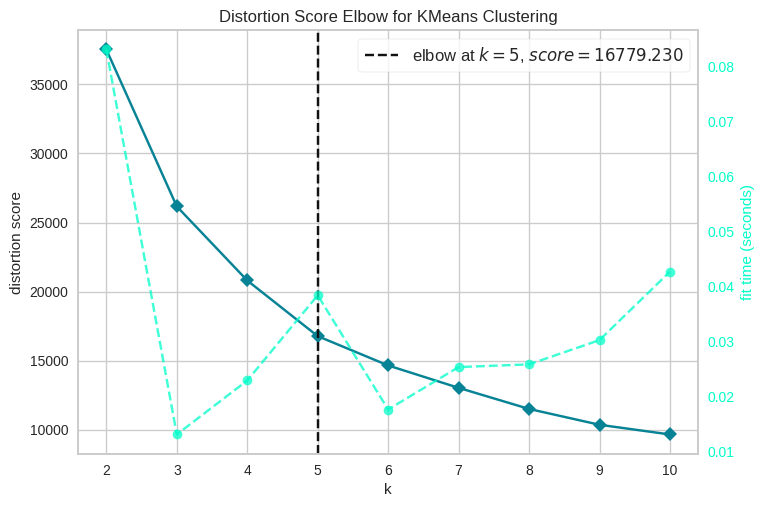

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
#Clustering

# Quick examination of elbow method to find numbers of clusters to make.

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(pca_df)
Elbow_M.show()

In [20]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(pca_df)
pca_df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
scaled_df["Clusters"]= yhat_AC

In [21]:
#Clustering Evaluation
scaled_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Clusters'],
      dtype='object')

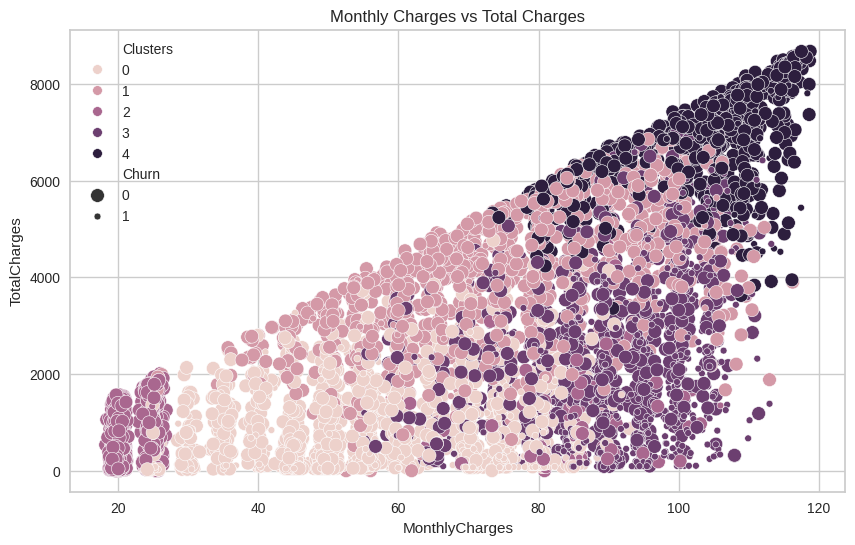

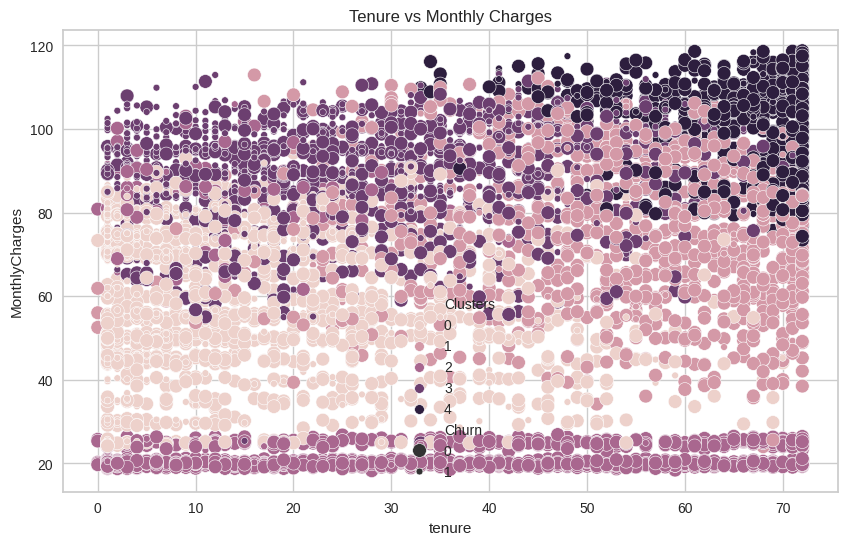

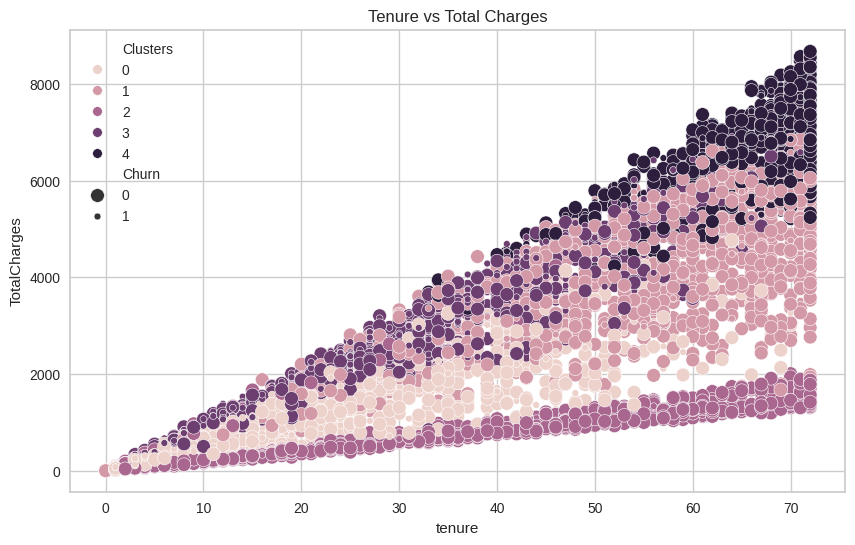

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['MonthlyCharges'], y=preprocessed_data['TotalCharges'], hue=scaled_df['Clusters'], size=preprocessed_data['Churn'])
plt.title('Monthly Charges vs Total Charges')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['tenure'], y=preprocessed_data['MonthlyCharges'], hue=scaled_df['Clusters'], size=preprocessed_data['Churn'])
plt.title('Tenure vs Monthly Charges')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['tenure'], y=preprocessed_data['TotalCharges'], hue=scaled_df['Clusters'], size=preprocessed_data['Churn'])
plt.title('Tenure vs Total Charges')
plt.show()

In [26]:
order = [4, 1, 3, 2, 0]

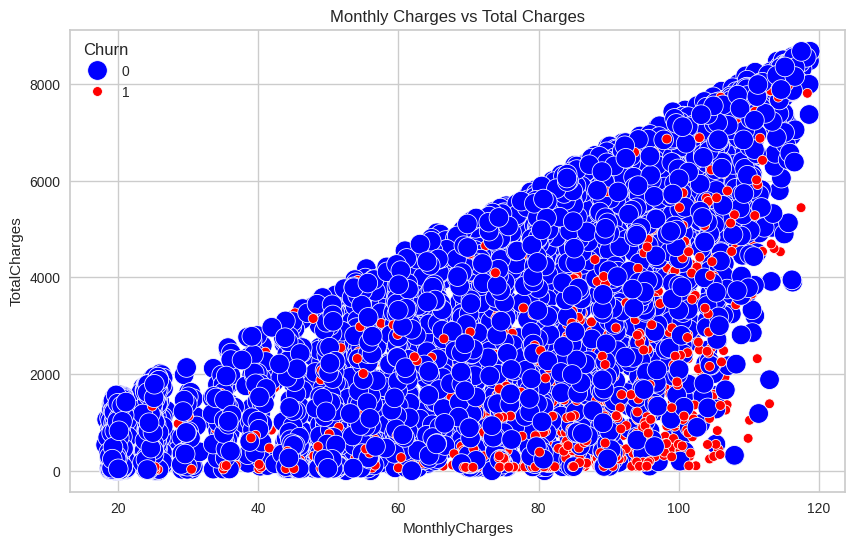

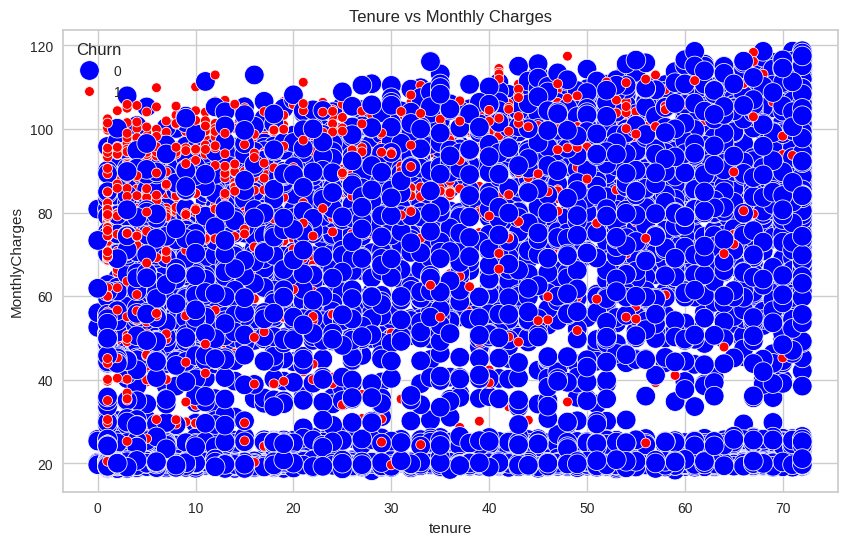

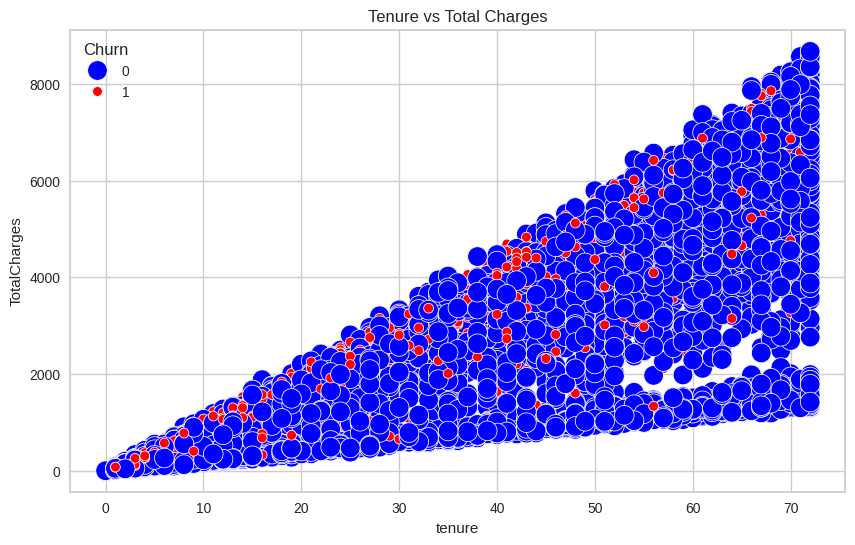

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['MonthlyCharges'], y=preprocessed_data['TotalCharges'], hue=preprocessed_data['Churn'], palette={0: 'blue', 1: 'red'}, size=preprocessed_data['Churn'], sizes=(50, 200))
plt.title('Monthly Charges vs Total Charges')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['tenure'], y=preprocessed_data['MonthlyCharges'], hue=preprocessed_data['Churn'], palette={0: 'blue', 1: 'red'}, size=preprocessed_data['Churn'], sizes=(50, 200))
plt.title('Tenure vs Monthly Charges')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=preprocessed_data['tenure'], y=preprocessed_data['TotalCharges'], hue=preprocessed_data['Churn'], palette={0: 'blue', 1: 'red'}, size=preprocessed_data['Churn'], sizes=(50, 200))
plt.title('Tenure vs Total Charges')
plt.show()

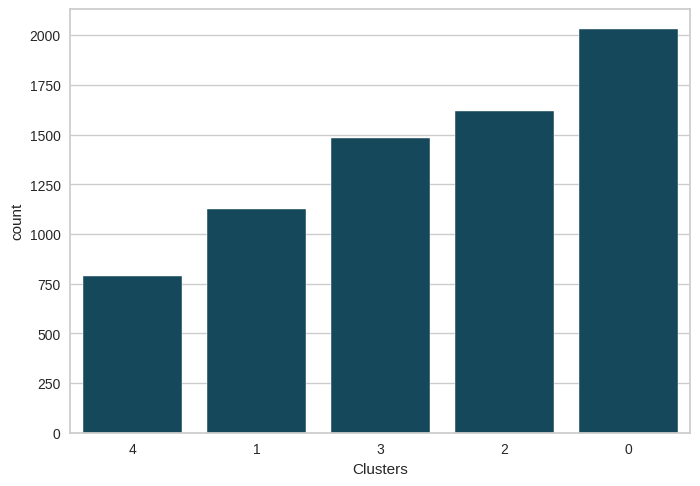

In [28]:
sns.set_palette(['#0A4D68', '#088395', '#05BFDB', '#00FFCA', '#B9EDDD'])
sns.countplot(scaled_df, x='Clusters', order=order);

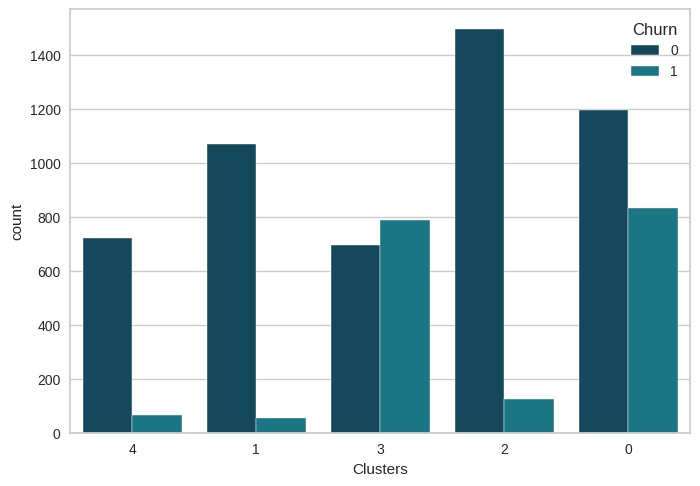

In [29]:
sns.countplot(scaled_df, x='Clusters', hue=preprocessed_data['Churn'], order=order);

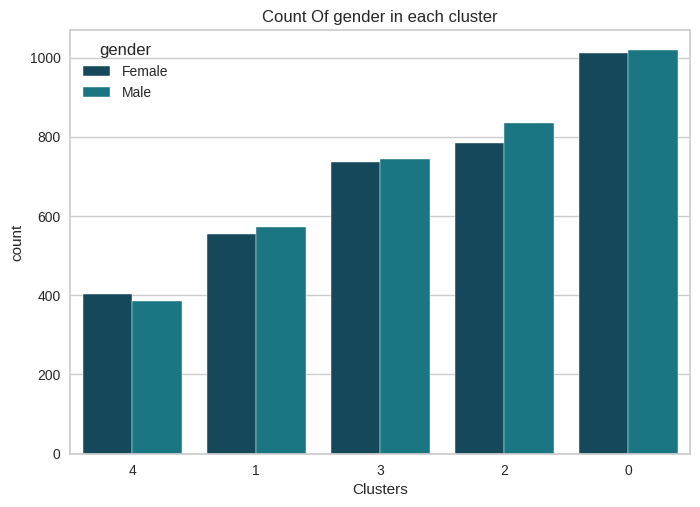

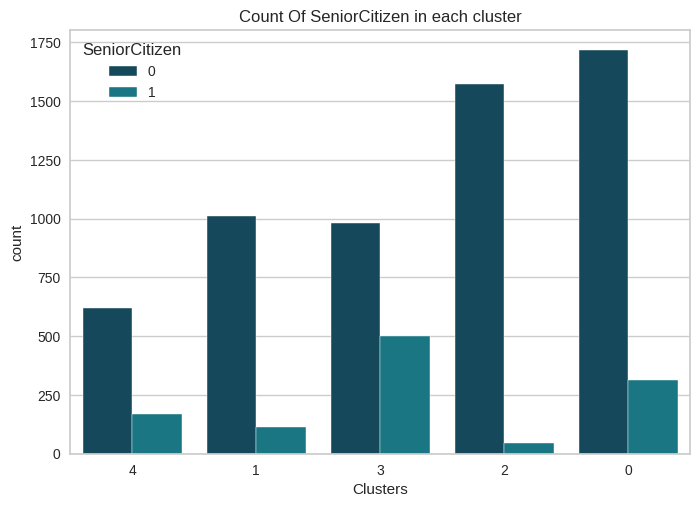

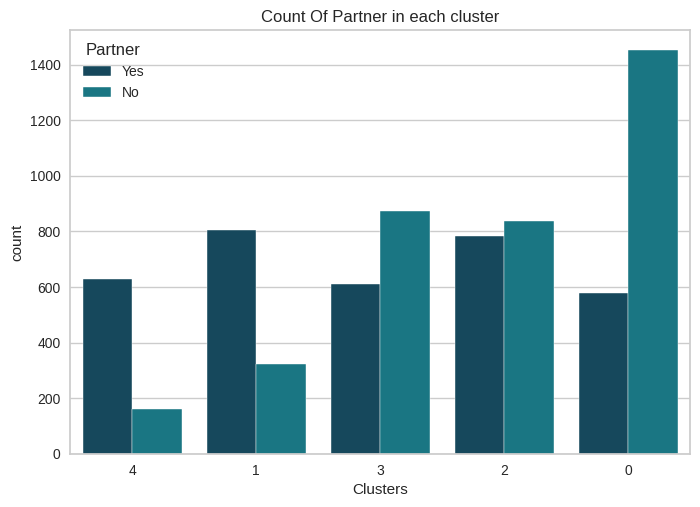

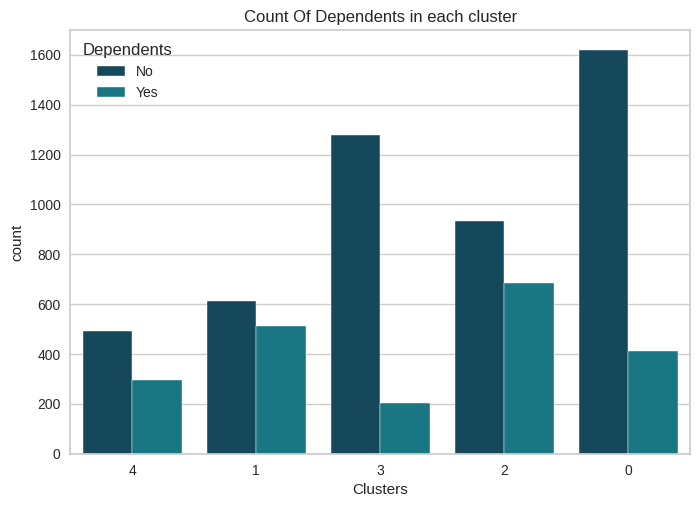

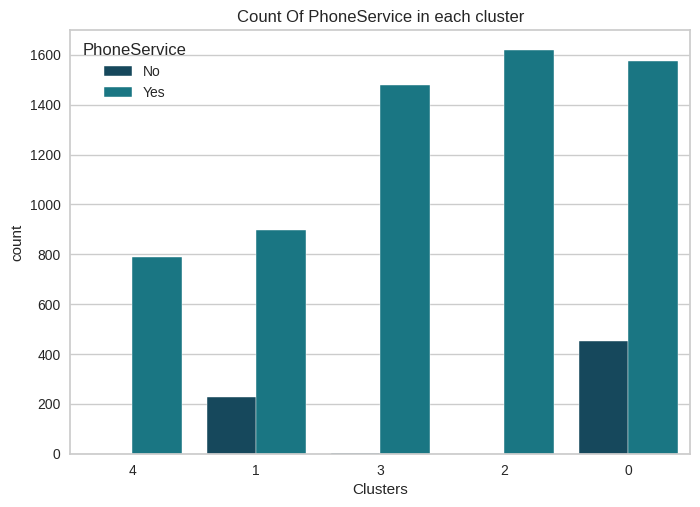

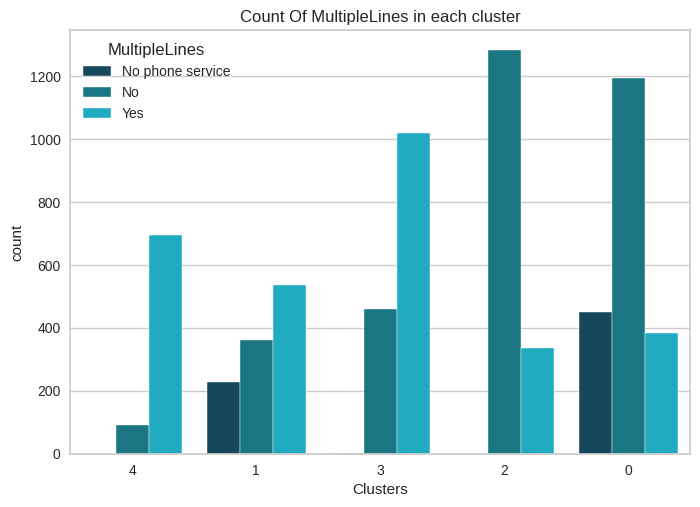

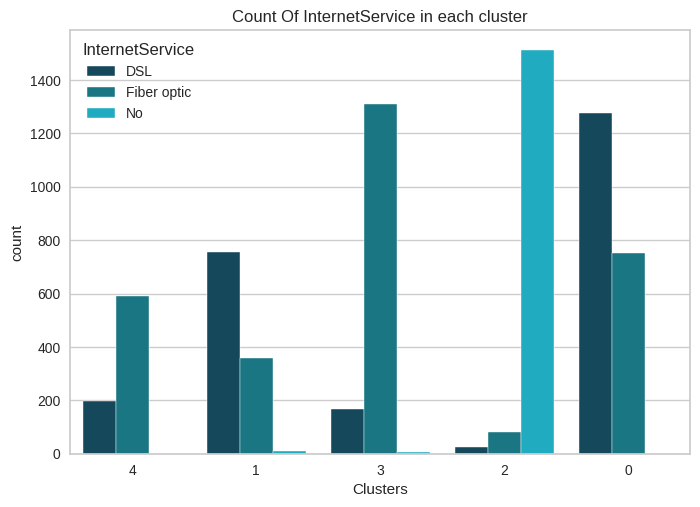

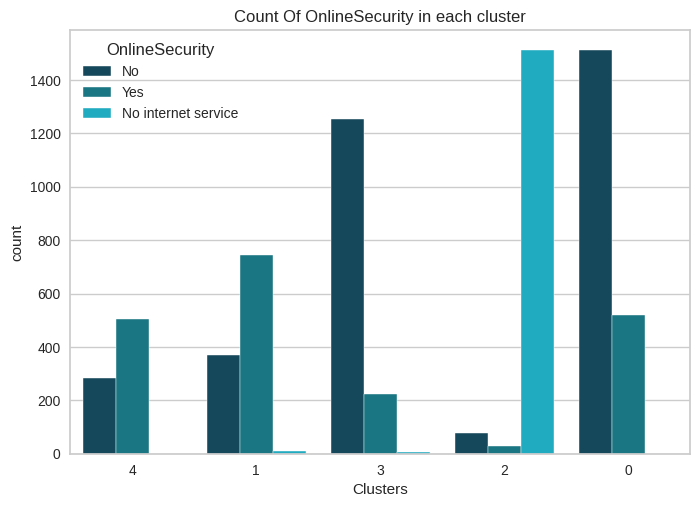

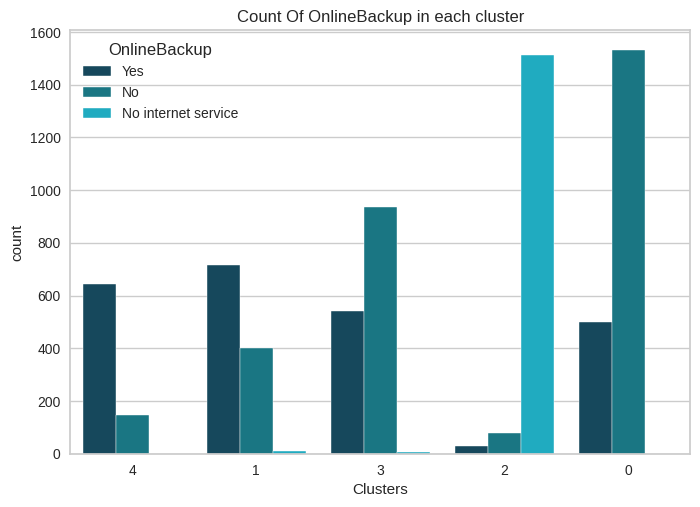

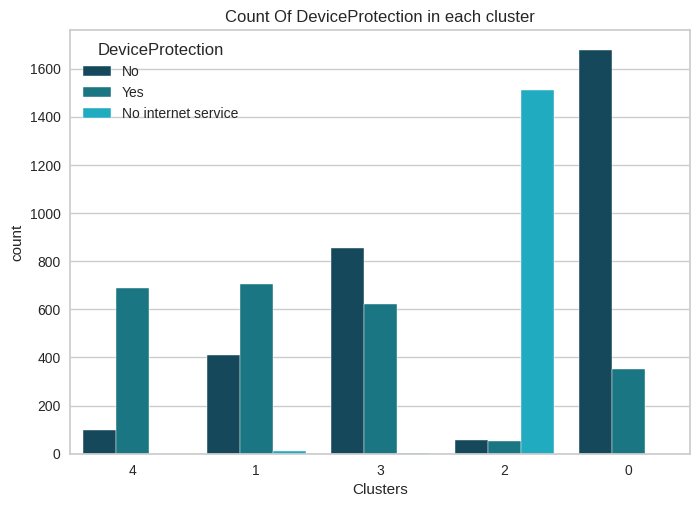

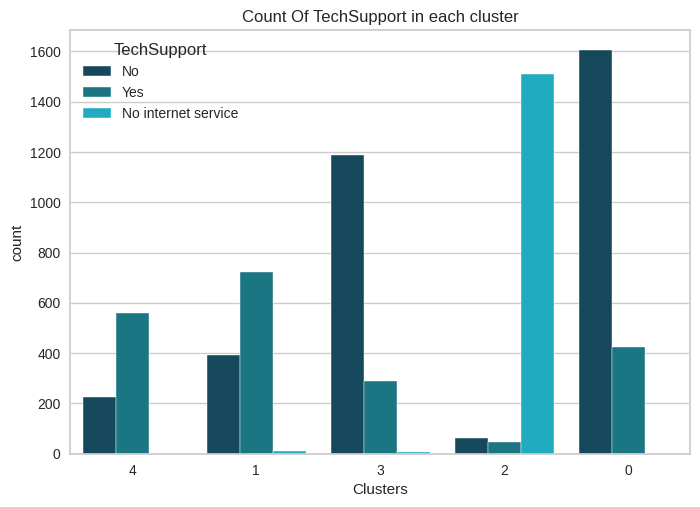

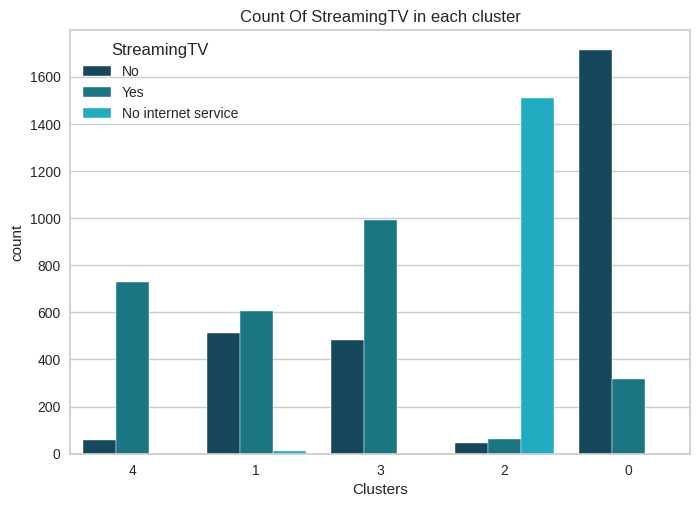

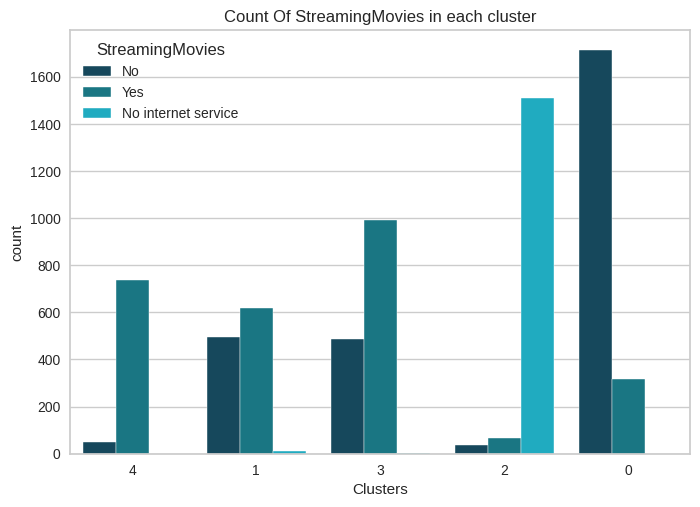

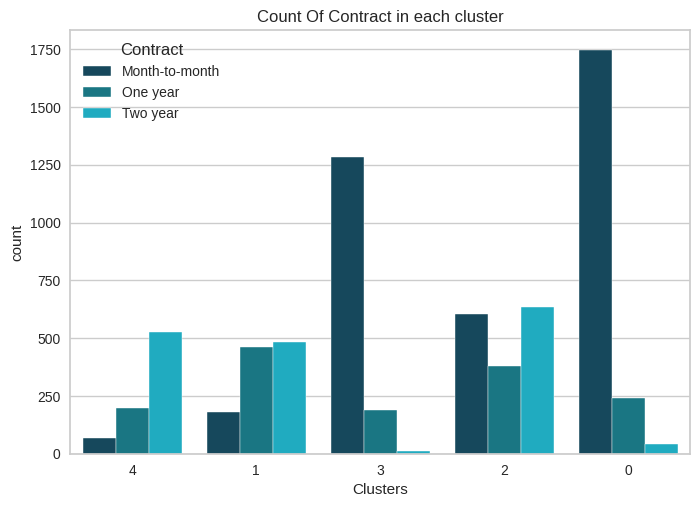

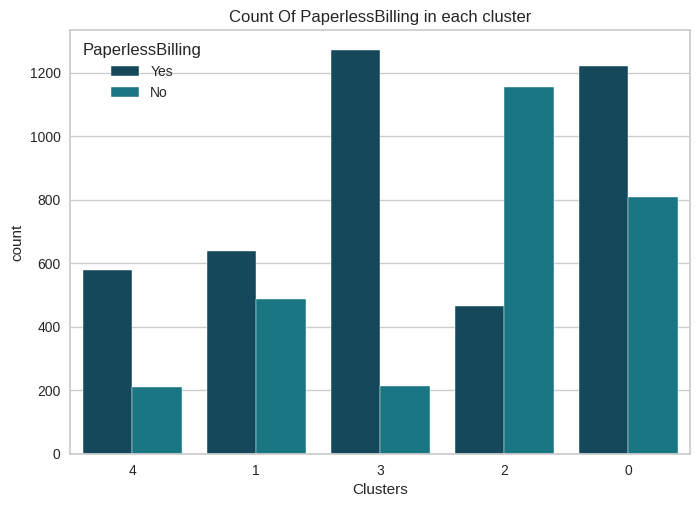

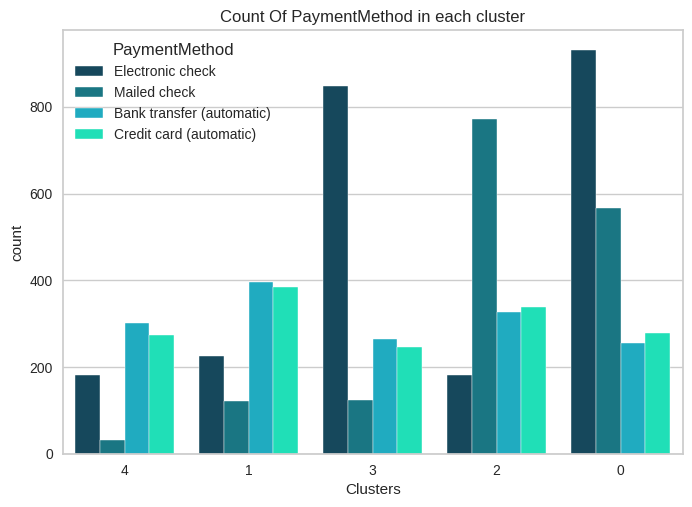

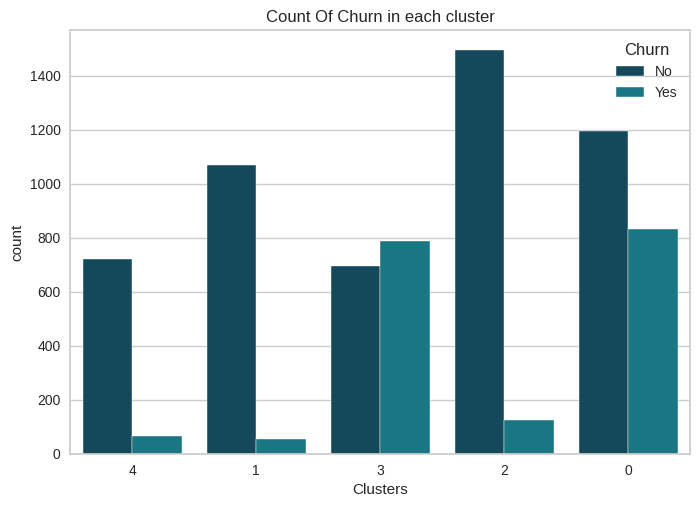

In [31]:
# Count plots for categorical features
data['Clusters'] = scaled_df['Clusters']
for col in categorical_features:
  pl = sns.countplot(data, x='Clusters', hue=col, order=order)
  pl.set_title(f"Count Of {col} in each cluster")
  plt.show()

<Axes: xlabel='Clusters', ylabel='TotalCharges'>

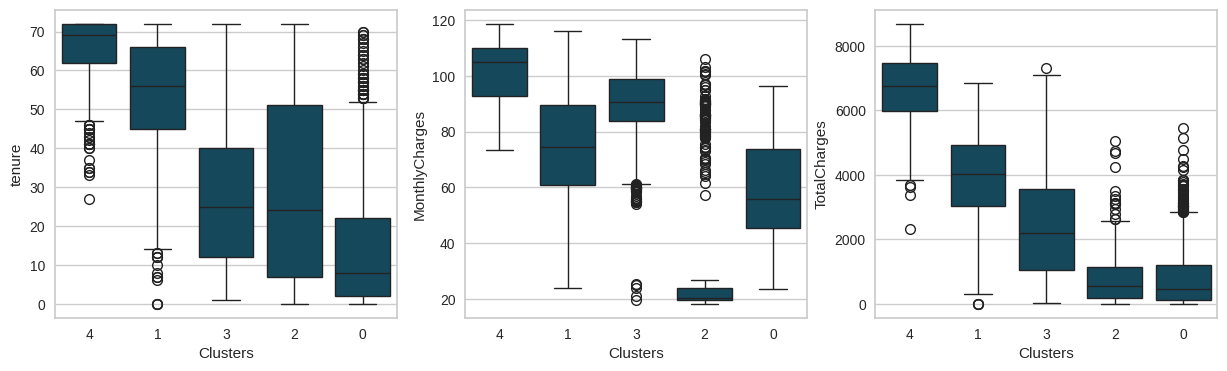

In [32]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sns.boxplot(data, x='Clusters', y='tenure', order=order)
plt.subplot(132)
sns.boxplot(data, x='Clusters', y='MonthlyCharges', order=order)
plt.subplot(133)
sns.boxplot(data, x='Clusters', y='TotalCharges', order=order)